
---

---
# Tracing the Flow of Collective Attention
---

---

> Cheng-Jun Wang ；Zhi-Cong Chen; Qiang Qin; Naipeng Chao *



Abstract: Collective attention becomes an increasingly scarce resource in the age of information explosion. To better understand the flow of collective attention, we construct the attention flow network using the anonymous smartphone data of 100000 users in a major city of China. In the constructed network, nodes are websites visited by users, and links denote the switch of users between two websites. We find that...  Finally, we discussed the benefits and limitations of computational communication research. 

Keywords: Digital Traces; Computational Communication; Computational Social Science;



In [1]:
%matplotlib inline
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
import re
import sys
import random
import numpy as np   
from numpy import delete
from numpy import linalg as LA
from urlparse import urlparse
from scipy.stats.stats import pearsonr
import networkx as nx
import statsmodels.api as sm
from collections import Counter, defaultdict
from math import sin, cos, sqrt, atan2, radians
import Image

In [90]:
# refreshing results
def flushPrint(variable):
    sys.stdout.write('\r')
    sys.stdout.write('%s' % variable)
    sys.stdout.flush()

# Timer    
def timer(func):
    import time
    start = time.clock() 
    flushPrint(start)
    result = func
    stop = time.clock()
    flushPrint(stop)
    elapsed = stop- start
    flushPrint("Time elapsed is: " + str(elapsed) )
    return result


# clean url
def urlclean(url):
    try:
        url = urlparse(url).hostname
        if url.replace('.','').isdigit(): return 'none'
        else:
            if len(url.split('.')) >=2 :
                if url[-6:]=='com.cn': return '.'.join(url.split('.')[-3:])
                return '.'.join(url.split('.')[-2:])
    except:
        return 'none'
    


def histogram (data,intervals,color,xlab):
    weights = np.ones_like(data)/len(data)
    plt.hist(data, intervals, facecolor = color, weights=weights, alpha = 0.75)
    plt.xlabel(xlab,size=16)
    plt.ylabel(r'$probability$',size=16)
    


#the function to convert latitude and longitude to pixel xy (Mercator projection)
def latLonToPixelXY(lat,lon,zoomS):
    mapW = 256*2**zoomS+0.0
    mapH = 256*2**zoomS+0.0
    x = (lon+180)*(mapW/360)# get x value
    latRad = lat*np.pi/180# convert from degrees to radians
    mercN = np.log(np.tan((np.pi/4)+(latRad/2)))# get y value
    y = (mapH/2)-(mapW*mercN/(2*np.pi))
    return x,y

# the function to retrieve google map
def Gmap(centerLat,centerLon,zoomS,pixelS,size,dark,saveAddress):
    url = 'http://maps.googleapis.com/maps/api/staticmap?sensor=false'\
    +'&size='+str(size)+'x'+str(size)+'&center='+str(centerLat)+','\
    +str(centerLon)+'&zoom='+str(zoomS)+'&scale='+str(pixelS)\
    +'&maptype=terrain'
    if dark==True:
        url = url+'&style=feature:all|element:all|saturation:-100|lightness:-70'
    buffer = StringIO(urllib.urlopen(url).read())
    image = Image.open(buffer)
    if saveAddress:
        image.save(saveAddress)
    else:
        image.show()

# the function to calculate the distance between two latitudes and longtitudes (in kilometers)
def dis(lat1,lon1,lat2,lon2):
    R = 6373.0 # convert Earth's radius in kilometers
    lat1 = radians(lat1)
    lon1 = radians(lon1)
    lat2 = radians(lat2)
    lon2 = radians(lon2)
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = (sin(dlat/2))**2 + cos(lat1) * cos(lat2) * (sin(dlon/2))**2
    c = 2 * atan2(sqrt(a), sqrt(1-a))
    distance = R * c
    return distance

#the function to belance a flow network
def flowBalancing(G):
    RG = G.reverse()
    H = G.copy()
    def nodeBalancing(node):
        outw=0
        for i in G.edges(node):
            outw+=G[i[0]][i[1]].values()[0]
        inw=0
        for i in RG.edges(node):
            inw+=RG[i[0]][i[1]].values()[0]
        deltaflow=inw-outw
        if deltaflow > 0:
            H.add_edge(node, "sink",weight=deltaflow)
        elif deltaflow < 0:
            H.add_edge("source", node, weight=abs(deltaflow))
        else:
            pass
    for i in G.nodes():
        nodeBalancing(i)
    if ("source", "source") in H.edges():  H.remove_edge("source", "source")
    if ("sink", "sink") in H.edges(): H.remove_edge("sink", "sink")
    return H

#the function to calculate the distance from source of nodes
def flowDistanceFromSource(G): #input a balanced nx graph
    R = G.reverse()
    mapping = {'source':'sink','sink':'source'}
    H = nx.relabel_nodes(R,mapping)
    #---------initialize flow distance dict------
    L = dict((i,1) for i in G.nodes())
    #---------prepare weighted out-degree dict------
    T = G.out_degree(weight='weight')
    #---------iterate until converge------------
    ls = np.array(L.values())
    delta = len(L)*0.01 + 1
    k=0
    while delta > len(L)*0.01:
        k+=1
        if k>20:
            break
        for i in L:
            l=1
            for m,n in H.edges(i):
                l+=L[n]*H[m][n].values()[0]/float(T[m])
            L[i]=l
        delta = sum(np.abs(np.array(L.values()) - ls))
        ls = np.array(L.values())
    #---------clean the result-------
    del L['sink']
    for i in L:
        L[i]-=1
    L['sink'] = L.pop('source')
    L['source'] = 0
    return L

# Constructing Data Frame

In [3]:
# import json

# import timeit
# start = timeit.default_timer()
# print start
# #Your statements here
# qprs = json.load(open("/Users/chengjun/bigdata/gprs_q_20150619.json"))
# stop = timeit.default_timer()
# print stop - start 
# #slow

In [4]:
# len(qprs)

In [5]:
# dat = []
# for k, i in enumerate(qprs):
#     if k % 1000 == 0:
#         flushPrint(k)
#     for j in qprs[i]:
#         j.insert(0, i)
#         dat.append(j)

In [6]:
# import pandas as pd

# df = pd.DataFrame(dat, columns = ['user', 'time', 'loc', 'website'])

In [7]:
# len(df)

In [13]:
# df.to_csv("/Users/chengjun/bigdata/gprs_q_20150619_pandas.txt", index = False, encoding = 'utf8')

# Loading Data and Cleaning

In [20]:
df = pd.read_csv("/Users/chengjun/bigdata/gprs_q_20150619_pandas.txt")
df[:3]

,user,time,loc,website
0,2668993,20131201181822,39.944951_116.515231,none
1,35468103,20131201163608,39.65311_116.033488,qq.com
2,35468103,20131201163608,39.65311_116.033488,qq.com


In [94]:
len(df)

38036269

In [95]:
df[:10]

,user,time,loc,website
0,2668993,20131201181822,39.944951_116.515231,none
1,35468103,20131201163608,39.65311_116.033488,qq.com
2,35468103,20131201163608,39.65311_116.033488,qq.com
3,35468103,20131201163608,39.65311_116.033488,qq.com
4,35468103,20131201163612,39.65311_116.033488,doubleclick.net
5,35468103,20131201163613,39.65311_116.033488,facebook.com
6,35468103,20131201163616,39.65311_116.033488,crashlytics.com
7,35468103,20131201163624,39.65311_116.033488,bmob.cn
8,35468103,20131201163625,39.65311_116.033488,ppstream.com
9,35468103,20131201163627,39.65311_116.033488,qq.com


In [21]:
df = df.drop_duplicates()
len(df)

23078053

In [97]:
df = df[df.website != 'none']
len(df)

20341880

In [98]:
df.website.iloc[0]

'qq.com'

In [99]:
help(df.dropna)

Help on method dropna in module pandas.core.frame:

dropna(self, axis=0, how='any', thresh=None, subset=None, inplace=False) method of pandas.core.frame.DataFrame instance
    Return object with labels on given axis omitted where alternately any
    or all of the data are missing
    
    Parameters
    ----------
    axis : {0 or 'index', 1 or 'columns'}, or tuple/list thereof
        Pass tuple or list to drop on multiple axes
    how : {'any', 'all'}
        * any : if any NA values are present, drop that label
        * all : if all values are NA, drop that label
    thresh : int, default None
        int value : require that many non-NA values
    subset : array-like
        Labels along other axis to consider, e.g. if you are dropping rows
        these would be a list of columns to include
    inplace : boolean, default False
        If True, do operation inplace and return None.
    
    Returns
    -------
    dropped : DataFrame



In [22]:
df = df.dropna(axis = 0)
len(df)

23070957

In [101]:
df[26:40]

,user,time,loc,website
41,32815620,20131201145323,39.933589_116.162134,qq.com
42,32815620,20131201145456,39.933589_116.162134,qq.com
43,32815620,20131201145704,39.933589_116.162134,qq.com
44,32815620,20131201150213,39.933589_116.162134,qq.com
45,32815620,20131201150551,39.933589_116.162134,qq.com
46,32815620,20131201150704,39.933589_116.162134,qq.com
47,32815620,20131201151205,39.933589_116.162134,qq.com
48,32815620,20131201151704,39.933589_116.162134,qq.com
49,32815620,20131201151714,39.933589_116.162134,qq.com
50,32815620,20131201152204,39.933589_116.162134,qq.com


# Data Description

In [23]:
uids = df.user.unique()
print uids, len(uids)

[  2668993  35468103  32815620 ...,  46186286 109735091  36735603] 92157


In [24]:
webs = df.website.unique()
print webs, len(webs)

['none' 'qq.com' 'doubleclick.net' ..., 'hneeeb.org' 'mqfww.com'
 'cmcsny.org'] 25751


In [104]:
df.time.min(), df.time.max()

(20131201000000, 20131202000000)

In [25]:
dfg = df.groupby(['website']).size()
dfg = dfg.sort_values( ascending= 0)
dfg[:10]

website
qq.com        4287432
none          2736173
baidu.com     1697581
qpic.cn       1296772
taobao.com     616067
360.cn         517147
qlogo.cn       427045
sinaimg.cn     398810
apple.com      313031
sohu.com       299500
dtype: int64

In [26]:
dfg_user = df.groupby(['website'])['user'].nunique().sort_values( ascending= 0)
dfg_user[:10]

website
none             69515
qq.com           61742
qpic.cn          36656
baidu.com        34506
qlogo.cn         29883
monternet.com    22201
apple.com        21836
360.cn           20221
umeng.com        14165
taobao.com       10992
Name: user, dtype: int64

In [225]:
help(df.to_csv)

Help on method to_csv in module pandas.core.frame:

to_csv(self, path_or_buf=None, sep=',', na_rep='', float_format=None, columns=None, header=True, index=True, index_label=None, mode='w', encoding=None, compression=None, quoting=None, quotechar='"', line_terminator='\n', chunksize=None, tupleize_cols=False, date_format=None, doublequote=True, escapechar=None, decimal='.', **kwds) method of pandas.core.frame.DataFrame instance
    Write DataFrame to a comma-separated values (csv) file
    
    Parameters
    ----------
    path_or_buf : string or file handle, default None
        File path or object, if None is provided the result is returned as
        a string.
    sep : character, default ','
        Field delimiter for the output file.
    na_rep : string, default ''
        Missing data representation
    float_format : string, default None
        Format string for floating point numbers
    columns : sequence, optional
        Columns to write
    header : boolean or list of str

In [226]:
# web_pv_uv = [ [i, dfg[i], dfg_user[i]]  for i in dfg.index]

# df_pvuv = pd.DataFrame(web_pv_uv, columns = ['web', 'pv', 'uv'])
# df_pvuv.to_csv('web_pv_uv.txt', index = False )

In [2]:
df_pvuv = pd.read_csv('web_pv_uv.txt')
print len(df_pvuv)
df_pvuv.head()

25750


,web,pv,uv
0,qq.com,4287432,61742
1,baidu.com,1697581,34506
2,qpic.cn,1296772,36656
3,taobao.com,616067,10992
4,360.cn,517147,20221


In [107]:
dfg_user[:50]

website
qq.com                  61742
qpic.cn                 36656
baidu.com               34506
qlogo.cn                29883
monternet.com           22201
apple.com               21836
360.cn                  20221
umeng.com               14165
taobao.com              10992
gtimg.cn                10692
gtimg.com                9985
sogou.com                9968
sina.cn                  9056
bdimg.com                9007
sinaimg.cn               8881
idqqimg.com              8654
ucweb.com                8413
duapp.com                7997
verisign.com             7537
weibo.cn                 7515
google-analytics.com     7090
flurry.com               6583
google.com               6573
uc.cn                    6569
sohu.com                 6184
alipay.com               5496
sina.com.cn              5254
autonavi.com             5227
aliyun.com               5063
ijinshan.com             4852
taobaocdn.com            4693
mi-idc.com               4642
alicdn.com               4582
do

In [29]:
dfg_merge = [[dfg_user[i], dfg[i] ] for i in dfg.index]

user, time = np.array(dfg_merge).T

In [17]:
# fitting function
def powerLawExponentialCutOffPlot(data, xlab, ylab):
    t = np.array(sorted(data,key=lambda x:-x))
    r = np.array(range(len(data))) +1
    r = r/float(np.max(r))
    y = np.log(r)
    x1 = np.log(t)
    x2 = t
    x = np.column_stack((x1,x2))
    x = sm.add_constant(x, prepend=True)
    res = sm.OLS(y,x).fit()
    L,alpha,lambde = res.params
    r2 = res.rsquared
    plt.plot(t,r,".",color="SteelBlue",alpha=0.75,markersize=10)
    plt.plot(t, np.exp(L) * t ** alpha * np.exp(lambde * t),"r-")
    plt.xscale('log'); plt.yscale('log')
    plt.ylim(ymax = 1)
    plt.xlabel(xlab, fontsize = 20)
    plt.ylabel(ylab, fontsize = 20)
    return [L,alpha,lambde, r2]

def powerPlot(data):
    d = sorted(data, reverse = True )
    d_table = defaultdict(int)
    for k in d:
        d_table[k] += 1
    d_value = sorted(d_table)
    d_freq = [d_table[i] for i in d_value]
    d_prob = [float(i)/sum(d_freq) for i in d_freq]
    #d_rank = ss.rankdata(d_value).astype(int)
    x = np.log(d_value)
    y = np.log(d_prob)
    xx = sm.add_constant(x, prepend=True)
    res = sm.OLS(y,xx).fit()
    constant,beta = res.params
    r2 = res.rsquared
    plt.plot(d_value, d_prob, 'ro')
    plt.plot(d_value, np.exp(constant+x*beta),"red")
    plt.xscale('log'); plt.yscale('log')
    plt.text(max(d_value)/5,max(d_prob)/5,
             'Beta = ' + str(round(beta,2)) +'\n' + 'R squared = ' + str(round(r2, 2)))
    plt.title('Size Distribution')
    plt.ylabel('Probability')
    plt.xlabel('Size')
    plt.show()  

def DGBDPlot(data):
    t=np.array(sorted(data,key=lambda x:-x))
    r=np.array(range(1,len(data)+1))   
    y = np.log(t)
    x1 = np.log(max(r)+1-r)
    x2 = np.log(r)
    x = np.column_stack((x1,x2))
    x = sm.add_constant(x, prepend=True)
    res = sm.OLS(y,x).fit()
    [A,b,a] = res.params
    plt.plot(r,t,"o",color="b")
    plt.plot(r, np.exp(A)*(max(r)+1-r)**b*r**a,"r-")
    plt.yscale('log')
    plt.text(max(r)/2,max(t)/50,"b=" + str(round(b,2)) + ", a=" + str(round(a,2)))
    plt.xlabel(r'Rank ')
    plt.ylabel(r'Frequency')

    
def gini_coefficient(v):
    bins = np.linspace(0., 100., 11)
    total = float(np.sum(v))
    yvals = []
    for b in bins:
        bin_vals = v[v <= np.percentile(v, b)]
        bin_fraction = (np.sum(bin_vals) / total) * 100.0
        yvals.append(bin_fraction)
    # perfect equality area
    pe_area = np.trapz(bins, x=bins)
    # lorenz area
    lorenz_area = np.trapz(yvals, x=bins)
    gini_val = (pe_area - lorenz_area) / float(pe_area)
    return bins, yvals, gini_val

import powerlaw
def plotPowerlaw(data,ax,col,xlab):
    fit = powerlaw.Fit(data,xmin=1)
    fit.plot_pdf(color = col, linewidth = 2)
    fit = powerlaw.Fit(data)
    a,x = (fit.power_law.alpha,fit.power_law.xmin)
    fit.power_law.plot_pdf(color = col, linestyle = 'dotted', ax = ax, \
                            label = r"$\alpha = %d \:\:, x_{min} = %d$" % (a,x))
#     minx,maxx=ax.get_xlim()
#     miny,maxy=ax.get_ylim()
#     ax.text(minx*5,maxy/10,r"$\alpha = %d \:\:, x_{min} = %d$" % (a,x), fontsize = 16)
    ax.set_xlabel(xlab, fontsize = 20)
    ax.set_ylabel('$Probability$', fontsize = 20)
    plt.legend(loc = 0, frameon = False)
    
def plotCCDF(data,ax,col,xlab):
    fit = powerlaw.Fit(data,xmin=1)
    fit.plot_ccdf(color = col, linewidth = 2)
    fit = powerlaw.Fit(data)
    a,x = (fit.power_law.alpha,fit.power_law.xmin)
    fit.power_law.plot_ccdf(color = col, linestyle = 'dotted', ax = ax, \
                            label = r"$\alpha = %d \:\:, x_{min} = %d$" % (a,x))
    ax.set_xlabel(xlab, fontsize = 16)
    ax.set_ylabel('$CCDF$', fontsize = 16)
    plt.legend(loc = 0, frameon = False)
    
def alloRegressPlot(xdata,ydata,col,mark,xlab,ylab, loglog):
    x=np.log(xdata+1);y=np.log(ydata+1);
    xx = sm.add_constant(x, prepend=True)
    res = sm.OLS(y,xx).fit()
    constant=res.params[0];beta=res.params[1]; r2=res.rsquared
    plt.plot(xdata,ydata,mark,color=col, label = None, alpha = 0.3)
    if loglog == True:
        plt.xscale('log');plt.yscale('log')
    plt.xlabel(xlab, fontsize = 20);plt.ylabel(ylab, fontsize = 20)
    minx,maxx=plt.xlim(); miny,maxy=plt.ylim()
    xs = np.linspace(min(xdata),max(xdata),100)
    plt.plot(xs,np.exp(constant)*xs**beta,color='r',linestyle='-', 
            label = '$\\alpha$ = '+ str(np.round(beta,2)) + ' , ' \
         + '$R^2$ = ' + str(np.round(r2,2)))
    plt.legend(loc = 0, frameon = False)

def linearRegressPlot(xdata,ydata,col,mark,xlab,ylab):
    x=xdata;y=ydata
    xx = sm.add_constant(x, prepend=True)
    res = sm.OLS(y,xx).fit()
    constant=res.params[0];beta=res.params[1]; r2=res.rsquared
    plt.plot(xdata,ydata,mark,color=col)
    plt.xlabel(xlab, fontsize = 20);plt.ylabel(ylab, fontsize = 20)
    minx,maxx=plt.xlim(); miny,maxy=plt.ylim()
    plt.text(min(xdata)+(max(xdata)-min(xdata))/10,
         min(ydata)+(max(ydata)-min(ydata))/2,
         '$\\alpha$ = '+ str(np.round(beta,2)) + ' , ' \
         + '$R^2$ = ' + str(np.round(r2,2)) )
    xs = np.linspace(min(xdata),max(xdata),100)
    plt.plot(xs,constant + xs*beta,color='r',linestyle='-')

Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


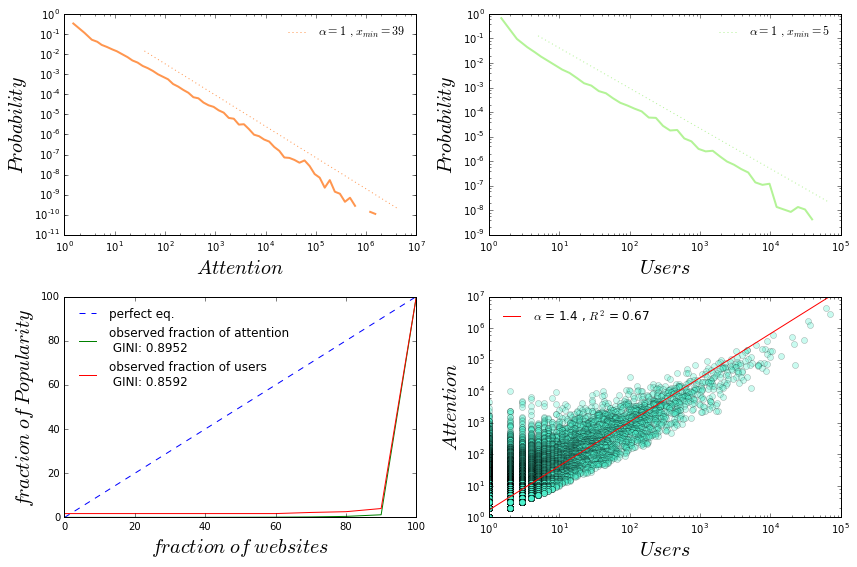

In [30]:
import matplotlib.cm as cm
cmap = cm.get_cmap('rainbow_r',6)

fig = plt.figure(figsize=(12, 8),facecolor='white')
ax = fig.add_subplot(2, 2, 1)
plotPowerlaw(dfg, ax,cmap(1), '$Attention$')
ax = fig.add_subplot(2, 2, 2)
plotPowerlaw(dfg_user, ax,cmap(2), '$Users$')

ax = fig.add_subplot(2, 2, 3)

bins, result, gini_val = gini_coefficient(dfg)
# fig = plt.figure(figsize=(8, 8),facecolor='white')
plt.plot(bins, bins, '--', label="perfect eq.")
plt.plot(bins, result, label="observed fraction of attention \n GINI: %.4f" %(gini_val))

bins, result, gini_val = gini_coefficient(dfg_user)
plt.plot(bins, result, label="observed fraction of users \n GINI: %.4f" %(gini_val))
plt.xlabel("$fraction\; of\; websites$", fontsize = 20)
plt.ylabel("$fraction \;of \;Popularity$", fontsize = 20)

plt.legend(loc = 0, frameon = False)

ax = fig.add_subplot(2, 2, 4)
alloRegressPlot(user,time, cmap(3),'o','$Users$','$Attention$', loglog=True)

plt.tight_layout()

plt.savefig('/Users/chengjun/百度云同步盘/Writing/AJOC CSS Special Issue/figures/allowmetric.tiff', dpi = 300)


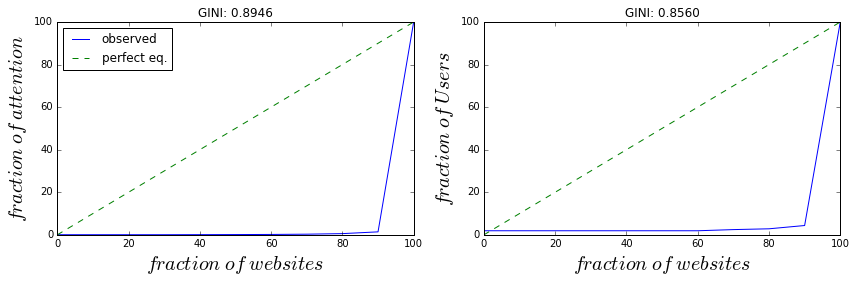

In [178]:

fig = plt.figure(figsize=(12, 4),facecolor='white')
ax = fig.add_subplot(1, 2, 1)

bins, result, gini_val = gini_coefficient(dfg)
# fig = plt.figure(figsize=(8, 8),facecolor='white')

plt.plot(bins, result, label="observed")
plt.plot(bins, bins, '--', label="perfect eq.")
plt.xlabel("$fraction\; of\; websites$", fontsize = 20)
plt.ylabel("$fraction \;of \;attention$", fontsize = 20)
plt.title("GINI: %.4f" %(gini_val))
plt.legend(loc = 0)
ax = fig.add_subplot(1, 2, 2)

bins, result, gini_val = gini_coefficient(dfg_user)
# fig = plt.figure(figsize=(8, 8),facecolor='white')

plt.plot(bins, result, label="observed")
plt.plot(bins, bins, '--', label="perfect eq.")
plt.xlabel("$fraction\; of\; websites$", fontsize = 20)
plt.ylabel("$fraction \;of \;Users$", fontsize = 20)
plt.title("GINI: %.4f" %(gini_val))

plt.tight_layout()
plt.show()

Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


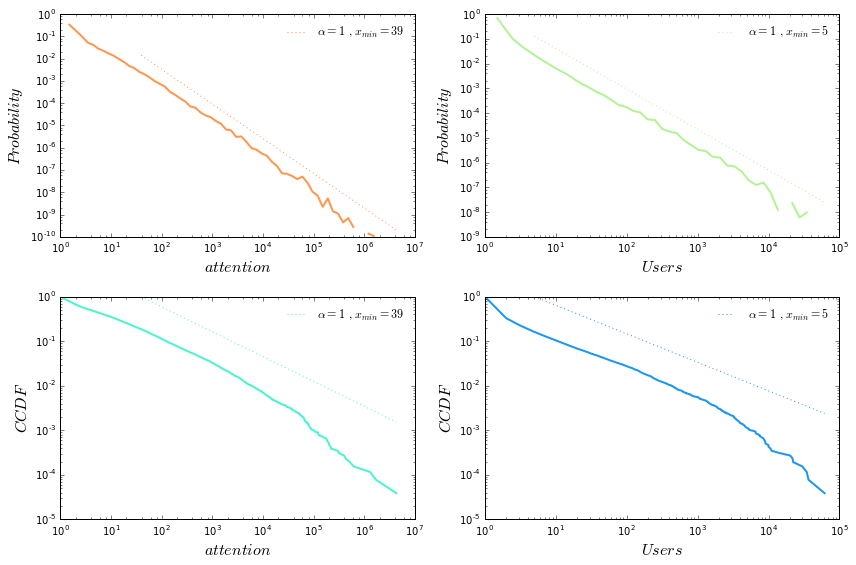

In [134]:
import matplotlib.cm as cm
cmap = cm.get_cmap('rainbow_r',6)

fig = plt.figure(figsize=(12, 8),facecolor='white')
ax = fig.add_subplot(2, 2, 1)
plotPowerlaw(dfg, ax,cmap(1), '$attention$')
ax = fig.add_subplot(2, 2, 2)
plotPowerlaw(dfg_user, ax,cmap(2), '$Users$')
ax = fig.add_subplot(2, 2, 3)
plotCCDF(dfg, ax,cmap(3), '$attention$')
ax = fig.add_subplot(2, 2, 4)
plotCCDF(dfg_user, ax,cmap(4), '$Users$')
plt.tight_layout()


[-0.12090779732866871,
 -0.46384133608334566,
 -1.4496598284545296e-06,
 0.97996185174257988]

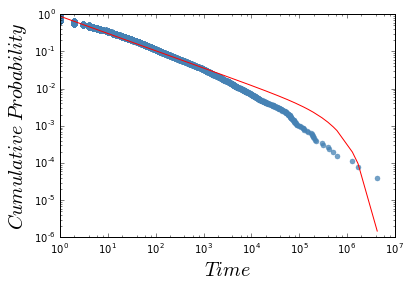

In [47]:
powerLawExponentialCutOffPlot(dfg, '$Time$', '$Cumulative \;Probability$')

[-0.51534363533299521,
 -0.72528884239681068,
 -1.9703589712294063e-05,
 0.91643432546728598]

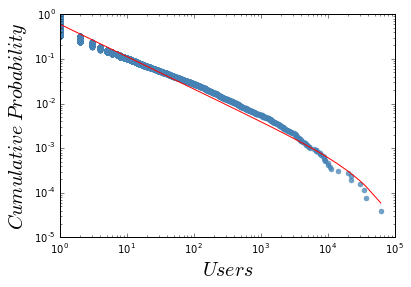

In [152]:
powerLawExponentialCutOffPlot(dfg_user, '$Users$', '$Cumulative \;Probability$')

[  3.68335134e-01   1.30876126e+00   3.93669047e+06]


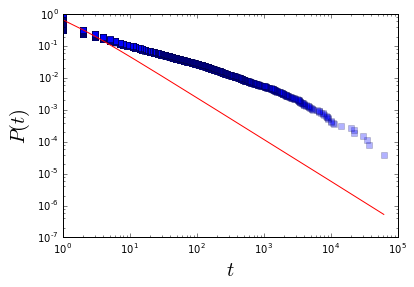

In [159]:
def func(x, x0, beta, K):
    return (x + x0) ** (-beta) * np.exp(-x/ K)

from scipy import optimize

# calculate P(rg)
data = dfg_user
# rg = sorted(data, reverse=True)
# rg = np.array(rg)
# prg = np.arange(len(rg)) / float(len(rg)-1)
x = np.array(sorted(data,key=lambda x:-x))
y = np.array(range(len(data))) +1
y = y/float(np.max(y))

popt, pcov = optimize.curve_fit(func, x, y)
print popt

plt.plot(x, y, 'bs', alpha = 0.3)
plt.plot(x, (x+popt[0])**-(popt[1])*np.exp(-x/popt[2]), 'r-' )
plt.yscale('log')
plt.xscale('log')
plt.xlabel('$t$', fontsize = 20)
plt.ylabel('$P(t)$', fontsize = 20)
plt.show()

# Constructing Flow Network

In [6]:
from flownetwork import flownetwork as fn
import networkx as nx

print fn.__version__

$version = 0.0.0.9$


In [110]:
dfi = df[df['user']==32815620]
dfi[:5]

,user,time,loc,website
26,32815620,20131201142312,39.933589_116.162134,qq.com
27,32815620,20131201142313,39.933589_116.162134,qq.com
28,32815620,20131201142453,39.933589_116.162134,qq.com
29,32815620,20131201142704,39.933589_116.162134,qq.com
30,32815620,20131201143204,39.933589_116.162134,qq.com


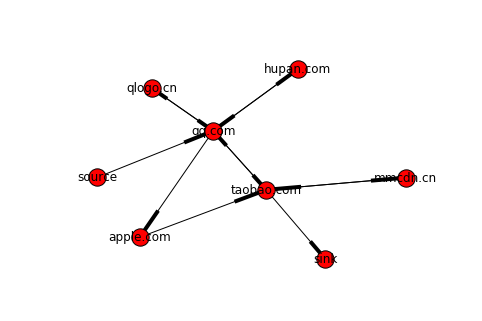

In [114]:
Ci = dfi[['user', 'website']]#[af_df['day']=='2016-10-01']
Ci = np.array(Ci)
gi = fn.constructFlowNetwork(Ci)
nx.draw(gi, with_labels = True)

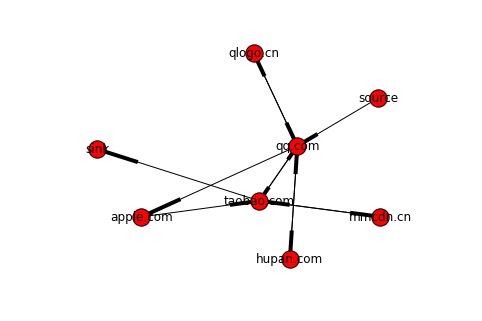

In [115]:
hi = fn.flowBalancing(gi)

nx.draw(hi, with_labels = True)

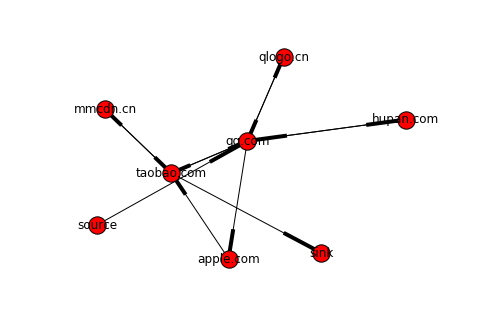

In [124]:
nx.write_edgelist(hi, "test.edgelist.txt")
hii=nx.read_edgelist("test.edgelist.txt",create_using=nx.DiGraph())

nx.draw(hii, with_labels = True)


In [117]:
C = df[['user', 'website']]#[af_df['day']=='2016-10-01']
C = np.array(C)
g = fn.constructFlowNetwork(C)

# Start from here

In [139]:
#nx.write_weighted_edgelist(g, "bjmobile.edgelist.txt", delimiter = '\t')

In [143]:
# gi = nx.read_weighted_edgelist("bjmobile.edgelist.txt", delimiter = '\t', create_using=nx.DiGraph())
# nx.info(gi)

'Name: \nType: DiGraph\nNumber of nodes: 25752\nNumber of edges: 363919\nAverage in degree:  14.1317\nAverage out degree:  14.1317'

In [3]:
edge_df = pd.read_csv("bjmobile.edgelist.txt", sep = '\t', names = ['source', 'target', 'weight'])
len(edge_df)

363920

In [4]:
g = nx.DiGraph()
for i in edge_df.index:
    g.add_edge(edge_df.source[i], edge_df.target[i], weight = edge_df.weight[i])
nx.info(g)

'Name: \nType: DiGraph\nNumber of nodes: 25752\nNumber of edges: 363920\nAverage in degree:  14.1317\nAverage out degree:  14.1317'

In [14]:
h = fn.flowBalancing(g)
nx.info(h)

'Name: \nType: DiGraph\nNumber of nodes: 25752\nNumber of edges: 363920\nAverage in degree:  14.1317\nAverage out degree:  14.1317'

In [183]:
nx.info(g)

'Name: \nType: DiGraph\nNumber of nodes: 25752\nNumber of edges: 363920\nAverage in degree:  14.1317\nAverage out degree:  14.1317'

In [7]:
di = fn.networkDissipate(g)

toSink,totalflow,fromSource = np.array(di.values()).T

toflow = totalflow-toSink
fromflow = totalflow - fromSource

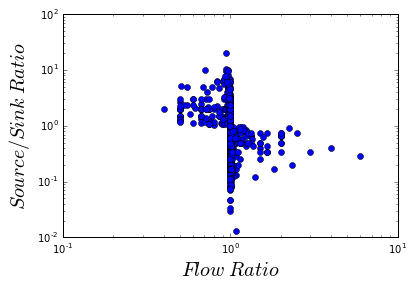

In [36]:
x = map(float, fromflow)/toflow 
y = map(float, fromSource)/toSink 
plt.plot(x, y, 'o')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('$Flow\;Ratio$', fontsize = 20)
plt.ylabel('$Source/Sink\;Ratio$', fontsize = 20)
plt.show()

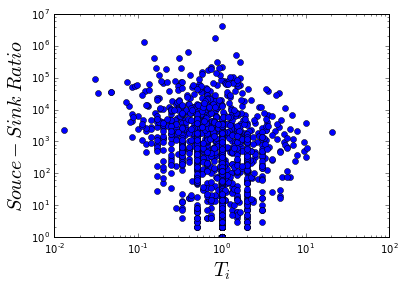

In [205]:
plt.plot(y, totalflow, 'o')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('$T_i$', fontsize = 20)
plt.ylabel('$Souce-Sink\;Ratio$', fontsize = 20)
plt.show()

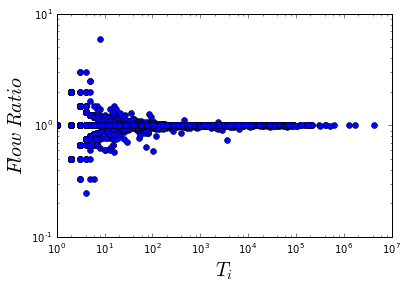

In [206]:
plt.plot(totalflow, x, 'o')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('$T_i$', fontsize = 20)
plt.ylabel('$Flow\;Ratio$', fontsize = 20)
plt.show()

In [8]:
def log_binning(x, y, bin_count=20):
    max_x = np.log10(max(x))
    max_y = np.log10(max(y))
    max_base = max([max_x,max_y])
    xx = [i for i in x if i>0]
    min_x = np.log10(np.min(xx))
    bins = np.logspace(min_x,max_base,num=bin_count)
    bin_means_y = (np.histogram(x,bins,weights=y)[0] / np.histogram(x,bins)[0])
    bin_means_x = (np.histogram(x,bins,weights=x)[0] / np.histogram(x,bins)[0])
    return bin_means_x,bin_means_y

def alloRegressPlot(xdata,ydata,col,mark,xlab,ylab, loglog):
    ti, di = log_binning(xdata,ydata)
    x=np.log(ti+0.1);y=np.log(di+0.1);
    xx = sm.add_constant(x, prepend=True)
    res = sm.OLS(y,xx).fit()
    constant=res.params[0];beta=res.params[1]; r2=res.rsquared
    plt.plot(xdata,ydata,mark,color=col, alpha = 0.3)
    plt.plot(ti, di, 'ro')
    xs = np.linspace(min(ti+1),max(ti+1),100)
    plt.plot(xs,np.exp(constant)*xs**beta,color='r',linestyle='-', 
             label = '$\\gamma$ = '+ str(np.round(beta,2)) + ' , ' \
         + '$R^2$ = ' + str(np.round(r2,3)))
    plt.legend(loc = 0)
    if loglog == True:
        plt.xscale('log');plt.yscale('log')
    plt.xlabel(xlab, fontsize = 20);plt.ylabel(ylab, fontsize = 20)
    minx,maxx=plt.xlim(); miny,maxy=plt.ylim()


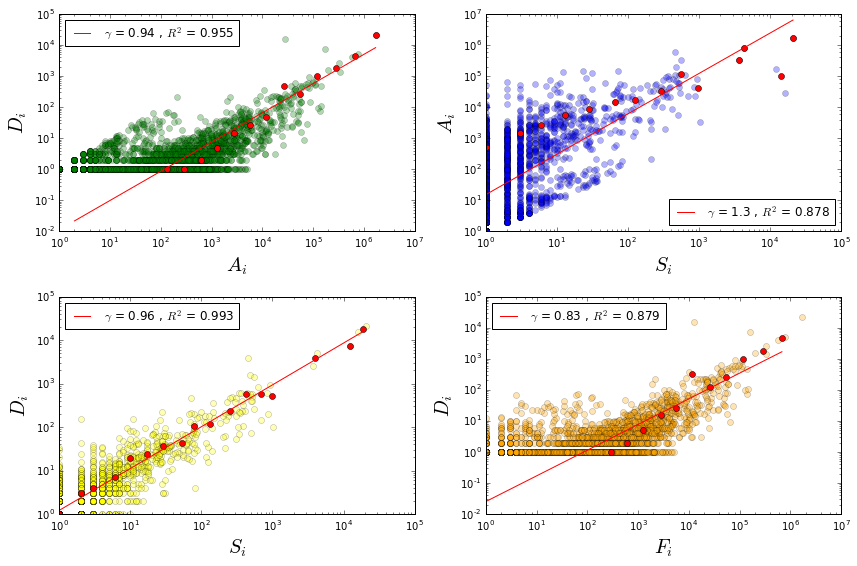

In [16]:
fig = plt.figure(figsize=(12, 8),facecolor='white')
ax = fig.add_subplot(2,2,1)
alloRegressPlot(totalflow,toSink,'g','o','$A_i$','$D_i$', True)
ax = fig.add_subplot(2,2,2)
alloRegressPlot(fromSource,totalflow,'b','o','$S_i$','$A_i$', True)
ax = fig.add_subplot(2,2,3)
alloRegressPlot(fromSource,toSink,'yellow','o','$S_i$','$D_i$', True)
ax = fig.add_subplot(2,2,4)
alloRegressPlot(toflow,toSink,'orange','o','$F_i$','$D_i$', True)
plt.tight_layout()
plt.savefig('/Users/chengjun/百度云同步盘/Writing/AJOC CSS Special Issue/figures/dissipation.tiff', dpi = 300)


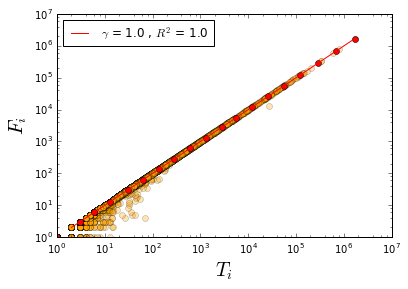

In [155]:
alloRegressPlot(totalflow, toflow,'orange','o','$T_i$','$F_i$', True)


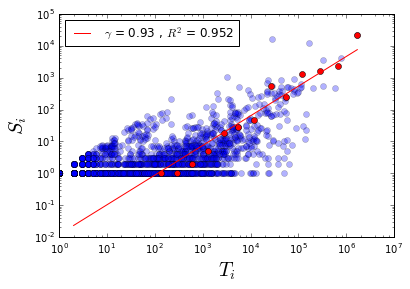

In [156]:
alloRegressPlot(totalflow, fromSource,'b','o','$T_i$','$S_i$', True)

In [37]:
from flownetwork import flownetwork as fn

In [16]:
fd = fn.flowDistanceFromSource(g)

In [17]:
fd.items()[:3]

[('iseesoft.cn', 34.492150491693359),
 ('niijhsk.com', 34.342646267045289),
 ('guomob.com', 34.447024446325628)]

In [18]:
di.items()[:3]

[('iseesoft.cn', [0, 1, 0]),
 ('niijhsk.com', [0, 1, 0]),
 ('guomob.com', [12, 8717, 6])]

In [12]:
aici = fn.getAICI(g)
aici.items()[:3]

[('iseesoft.cn', [1.0, 139.99831650259915]),
 ('niijhsk.com', [1.0, 138.49875643793075]),
 ('guomob.com', [8717.0, 883167.33044646587])]

In [14]:
ai, ci = np.array(aici.values()).T

In [40]:
def alloRegressPlot(xdata,ydata,col,mark,xlab,ylab, loglog):
    x=np.log(xdata+1);y=np.log(ydata+1);
    xx = sm.add_constant(x, prepend=True)
    res = sm.OLS(y,xx).fit()
    constant=res.params[0];beta=res.params[1]; r2=res.rsquared
    plt.plot(xdata,ydata,mark,color=col, label = None, alpha = 0.3)
    if loglog == True:
        plt.xscale('log');plt.yscale('log')
    plt.xlabel(xlab, fontsize = 20);plt.ylabel(ylab, fontsize = 20)
    minx,maxx=plt.xlim(); miny,maxy=plt.ylim()
    xs = np.linspace(min(xdata),max(xdata),100)
    plt.plot(xs,np.exp(constant)*xs**beta,color='r',linestyle='-', 
            label = '$\\eta$ = '+ str(np.round(beta,2)) + ' , ' \
         + '$R^2$ = ' + str(np.round(r2,2)))
    plt.legend(loc = 0, frameon = False)

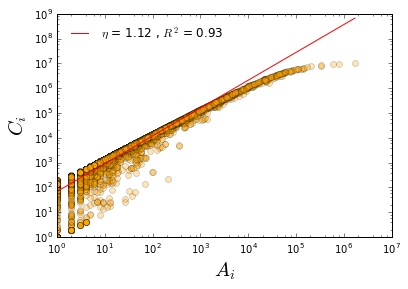

In [43]:
alloRegressPlot(ai,ci,'orange','o','$A_i$','$C_i$', loglog=True)

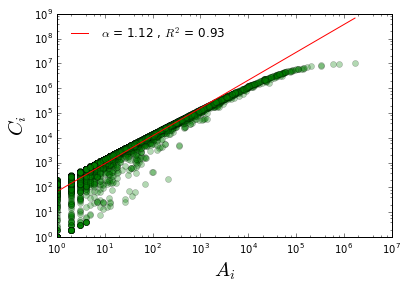

In [15]:
fn.alloRegressPlot(ai,ci,'g','o','$A_i$','$C_i$', loglog=True)
plt.savefig('/Users/chengjun/百度云同步盘/Writing/AJOC CSS Special Issue/figures/flowimpact.tiff', dpi = 300)


Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


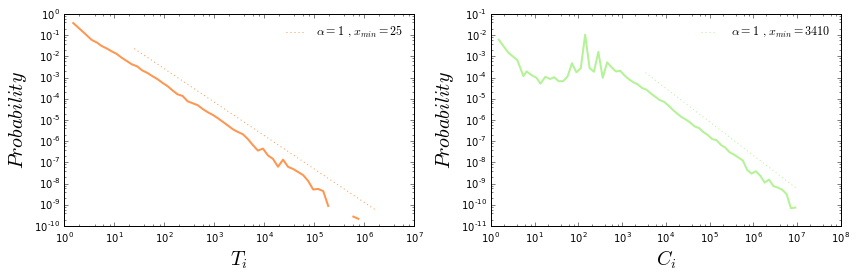

In [168]:
import matplotlib.cm as cm
cmap = cm.get_cmap('rainbow_r',6)

fig = plt.figure(figsize=(12, 4),facecolor='white')
ax = fig.add_subplot(1, 2, 1)
fn.plotPowerlaw(ai, ax,cmap(1), '$A_i$')
ax = fig.add_subplot(1, 2, 2)
fn.plotPowerlaw(ci, ax,cmap(2), '$C_i$')
plt.tight_layout()

In [159]:
len(ai), len(fd), len(di)

(25750, 25751, 25750)

In [163]:
fd['sink']

29.775361709179325

In [22]:
df_pvuv = pd.read_csv('web_pv_uv.txt')
print len(df_pvuv)
df_pvuv.head()

25750


,web,pv,uv
0,qq.com,4287432,61742
1,baidu.com,1697581,34506
2,qpic.cn,1296772,36656
3,taobao.com,616067,10992
4,360.cn,517147,20221


In [32]:
dic_pvuv = defaultdict(list)
for i in df_pvuv.index:
    dic_pvuv[df_pvuv.web[i]] = [df_pvuv.pv[i], df_pvuv.uv[i]]

In [33]:
dic_pvuv.items()[:3]

[('iseesoft.cn', [1, 1]),
 ('niijhsk.com', [1, 1]),
 ('guomob.com', [14042, 193])]

In [37]:
dii = {}
for i in di:
    if i in dic_pvuv:
        dii[i]=[di[i][0], di[i][1], di[i][2], fd[i], aici[i][1], dic_pvuv[i][0], dic_pvuv[i][1]]

In [38]:
dii.items()[:3]

[('iseesoft.cn', [0, 1, 0, 34.492150491693359, 139.99831650259918, 1, 1]),
 ('niijhsk.com', [0, 1, 0, 34.342646267045289, 138.49875643793075, 1, 1]),
 ('guomob.com',
  [12, 8717, 6, 34.447024446325628, 883167.33044646587, 14042, 193])]

In [56]:
len(dii)

25750

In [65]:
diif = pd.DataFrame(dii.values(), index = dii.keys(),
                    columns = ['toSink','totalflow','fromSource', 'flowdistance', 'ci' , 'pv', 'uv'])

diif = diif.sort_values('pv', ascending = False)
diif[:20]

,toSink,totalflow,fromSource,flowdistance,ci,pv,uv
qq.com,21113,1706835,20988,33.998514,1.018421e+07,4287432,61742
baidu.com,5116,781424,4266,34.862199,9.531049e+06,1697581,34506
qpic.cn,3963,585835,460,35.029982,9.198467e+06,1296772,36656
taobao.com,1397,332329,549,34.760115,8.180788e+06,616067,10992
360.cn,2540,331091,3690,34.917160,8.554837e+06,517147,20221
qlogo.cn,1551,200936,480,33.708680,7.558933e+06,427045,29883
sinaimg.cn,466,142064,72,34.720202,6.112034e+06,398810,8881
apple.com,7356,168168,12250,32.158549,7.386142e+06,313031,21836
sohu.com,517,107535,458,34.089564,5.765905e+06,299500,6184
ucweb.com,917,82359,924,33.766049,5.328427e+06,219886,8413


In [67]:
diif.corr()

,toSink,totalflow,fromSource,flowdistance,ci,pv,uv
toSink,1.000000,0.791197,0.975372,-0.018486,0.417408,0.806049,0.798987
totalflow,0.791197,1.000000,0.703322,0.000778,0.630807,0.992006,0.892637
fromSource,0.975372,0.703322,1.000000,-0.020158,0.376962,0.716881,0.728768
flowdistance,-0.018486,0.000778,-0.020158,1.000000,0.004642,-0.000033,-0.006193
ci,0.417408,0.630807,0.376962,0.004642,1.000000,0.555323,0.780746
pv,0.806049,0.992006,0.716881,-0.000033,0.555323,1.000000,0.858216
uv,0.798987,0.892637,0.728768,-0.006193,0.780746,0.858216,1.000000


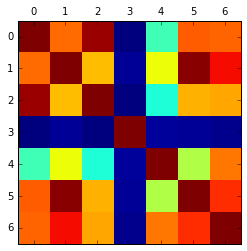

In [66]:
plt.matshow(diif.corr())

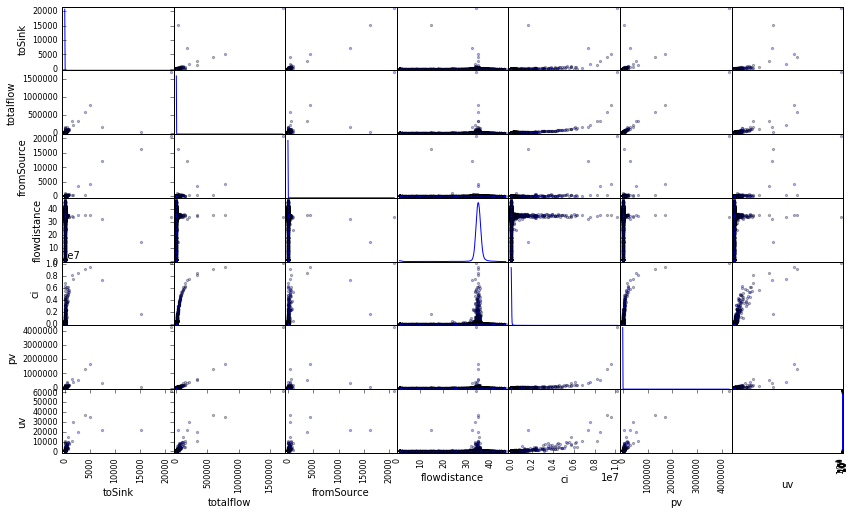

In [69]:
pd.scatter_matrix(diif, alpha = 0.3, figsize = (14,8), diagonal = 'kde');
plt.xscale('log')
plt.yscale('log')

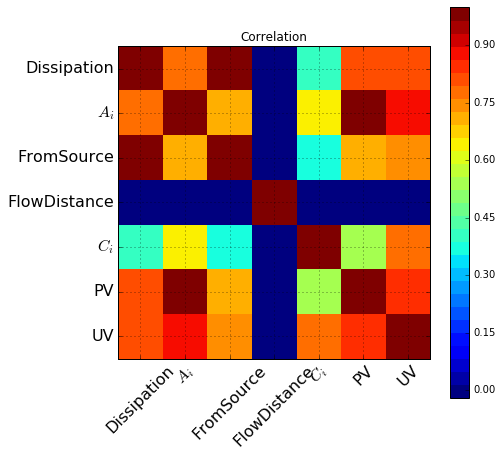

In [82]:
def correlation_matrix(df):
    from matplotlib import pyplot as plt
    from matplotlib import cm as cm

    fig = plt.figure(figsize=(7, 7),facecolor='white')
    ax1 = fig.add_subplot(111)
    cmap = cm.get_cmap('jet', 30)
    cax = ax1.imshow(df.corr(), interpolation="nearest", cmap=cmap)
    ax1.grid(True)
    plt.title('Correlation')
    labels=['Dissipation','Dissipation','$A_i$','FromSource','FlowDistance','$C_i$','PV','UV',]
    ax1.set_xticklabels(labels,fontsize=16, rotation = 45)
    ax1.set_yticklabels(labels,fontsize=16)
    # Add colorbar, make sure to specify tick locations to match desired ticklabels
    fig.colorbar(cax)
    plt.show()

correlation_matrix(diif)

In [95]:
diif.columns.values 


array(['toSink', 'totalflow', 'fromSource', 'flowdistance', 'ci', 'pv',
       'uv'], dtype=object)

(array([   303.,    103.,     96.,    109.,    105.,    143.,    574.,
         23635.,    604.,     70.]),
 array([  1. ,   5.6,  10.2,  14.8,  19.4,  24. ,  28.6,  33.2,  37.8,
         42.4,  47. ]),
 <a list of 10 Patch objects>)

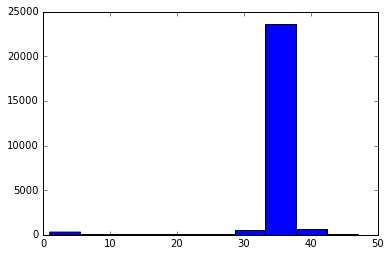

In [106]:
plt.hist(diif.flowdistance)

In [126]:
import statsmodels.formula.api as smf

diif['pv_log'] = np.log(diif.pv+1)
diif['toSink_log'] = np.log(diif.toSink+1)
diif['fromSource_log'] = np.log(diif.fromSource+1)
diif['ci_log'] = np.log(diif.ci+1)

lm = smf.ols(formula='pv_log ~ toSink_log + fromSource_log + ci_log + flowdistance', data=diif).fit()
print lm.summary()

# constant, beta1, beta2, beta3 = lm.params
# r2=lm.rsquared
# print constant, beta1, beta2, beta3, r2

                            OLS Regression Results                            
Dep. Variable:                 pv_log   R-squared:                       0.924
Model:                            OLS   Adj. R-squared:                  0.924
Method:                 Least Squares   F-statistic:                 7.823e+04
Date:                Sun, 04 Jun 2017   Prob (F-statistic):               0.00
Time:                        18:47:00   Log-Likelihood:                -19735.
No. Observations:               25742   AIC:                         3.948e+04
Df Residuals:                   25737   BIC:                         3.952e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------
Intercept         -1.1829      0.026    -45.

In [127]:
help(sm.graphics.plot_partregress_grid)

Help on function plot_partregress_grid in module statsmodels.graphics.regressionplots:

plot_partregress_grid(results, exog_idx=None, grid=None, fig=None)
    Plot partial regression for a set of regressors.
    
    Parameters
    ----------
    results : results instance
        A regression model results instance
    exog_idx : None, list of ints, list of strings
        (column) indices of the exog used in the plot, default is all.
    grid : None or tuple of int (nrows, ncols)
        If grid is given, then it is used for the arrangement of the subplots.
        If grid is None, then ncol is one, if there are only 2 subplots, and
        the number of columns is two otherwise.
    fig : Matplotlib figure instance, optional
        If given, this figure is simply returned.  Otherwise a new figure is
        created.
    
    Returns
    -------
    fig : Matplotlib figure instance
        If `fig` is None, the created figure.  Otherwise `fig` itself.
    
    Notes
    -----
    A 

In [131]:
range(1, 4)

[1, 2, 3]

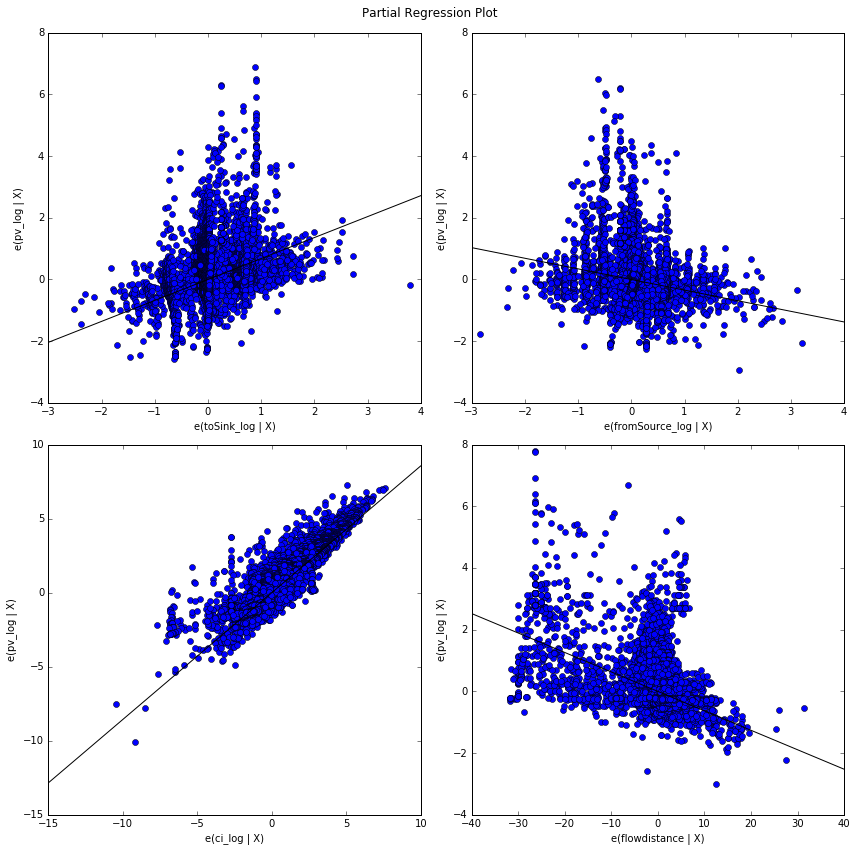

In [133]:
fig = plt.figure(figsize=(12,12))
fig = sm.graphics.plot_partregress_grid(lm, fig = fig, exog_idx = range(1,5))
plt.show()

# More website data

In [84]:
with open ('/Users/chengjun/bigdata/gprs_bh_20131201.del') as f:
    line = f.readline()

In [88]:
for i in line.strip().split(','):
    print i

31000773
2

"4541"
"55606"
"116.345373"
"39.998725"
"QQ"
"社交沟通"
"QQ"
"社交沟通"
"20131201002143"
+0000000000000003.0000
+0000000000000012.0000
+0000000000000515.0000
+0000000000014292.0000
"腾讯网"
"	QQ空间图片"
"博客类"
"动作"
"博客公共网站资源"
"http://s3.photo.store.qq.com/http_imgload.cgi?/rurl2=339af54fb88139ce384086c2900d1551bbf0a7fef75531567a07314a1805195c7127b2204679335ba470942d4802c7dbed2b7e24115e614eb276abe0e4aa06a7094e131d4206f585356cce2386decf8aacedbe1f"


In [91]:
urlclean("http://s3.photo.store.qq.com/http_imgload.cgi?/rurl2=339af54fb88139ce384086c2900d1551bbf0a7fef75531567a07314a1805195c7127b2204679335ba470942d4802c7dbed2b7e24115e614eb276abe0e4aa06a7094e131d4206f585356cce2386decf8aacedbe1f")

'qq.com'

In [94]:
import json
webcat = json.load(open('/Users/chengjun/bigdata/bjmobile_webcat.json') )
for i in webcat['qq.com']:
    print i

"社交沟通"
"其他资讯"
"应用商店"
"游戏"
"音乐"
"视频"

"邮箱"
"阅读"
"软件工具"
"生活服务"
"位置"
"浏览"
"社区论坛"
"电商购物"
"搜索"


# Clustering 

t-SNE: 22 sec


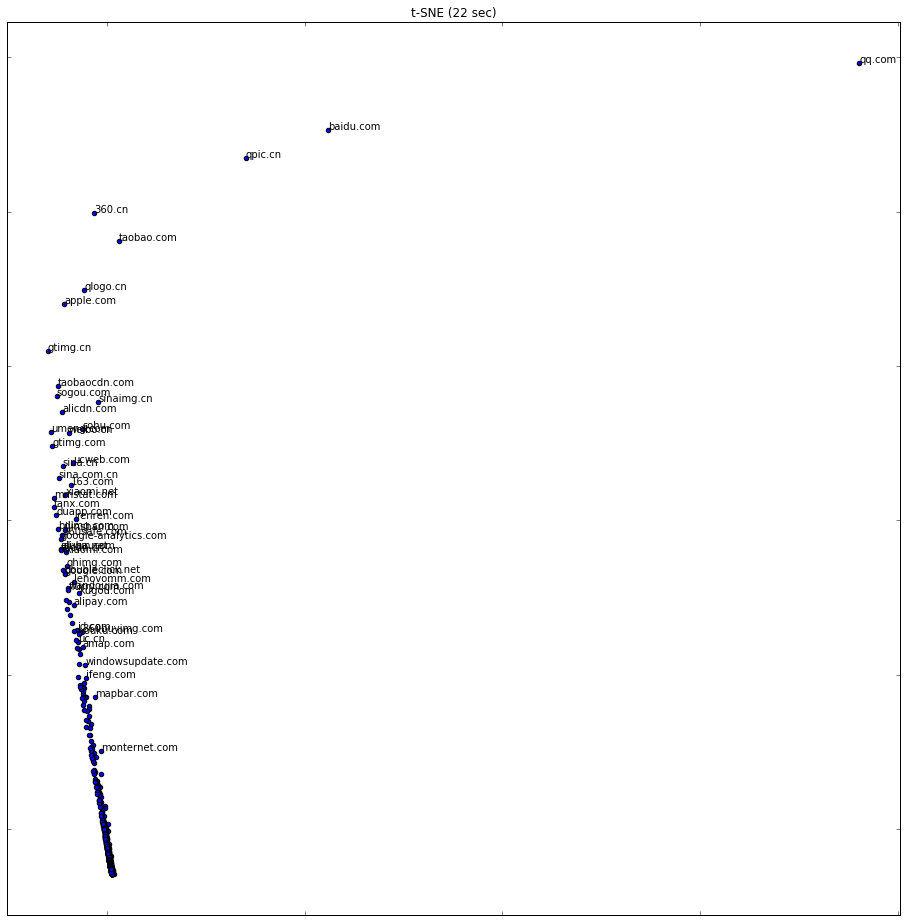

In [63]:
from time import time

from sklearn import manifold
from sklearn.utils import check_random_state

data = diif[:1000]
# Perform t-distributed stochastic neighbor embedding.
t0 = time()
tsne = manifold.TSNE(n_components=2, init='pca', random_state=0, method = 'exact')
trans_data = tsne.fit_transform(data).T
t1 = time()
print("t-SNE: %.2g sec" % (t1 - t0))

from matplotlib.ticker import NullFormatter

fig = plt.figure(figsize=(16, 16),facecolor='white')
ax = fig.add_subplot(1, 1, 1)
plt.scatter(trans_data[1], trans_data[0])  # c=colors

for i in range(50):
    plt.text(trans_data[1][i], trans_data[0][i], diif.index[i])  # c=colors
plt.title("t-SNE (%.2g sec)" % (t1 - t0))
ax.xaxis.set_major_formatter(NullFormatter())
ax.yaxis.set_major_formatter(NullFormatter())
plt.axis('tight')
plt.show()

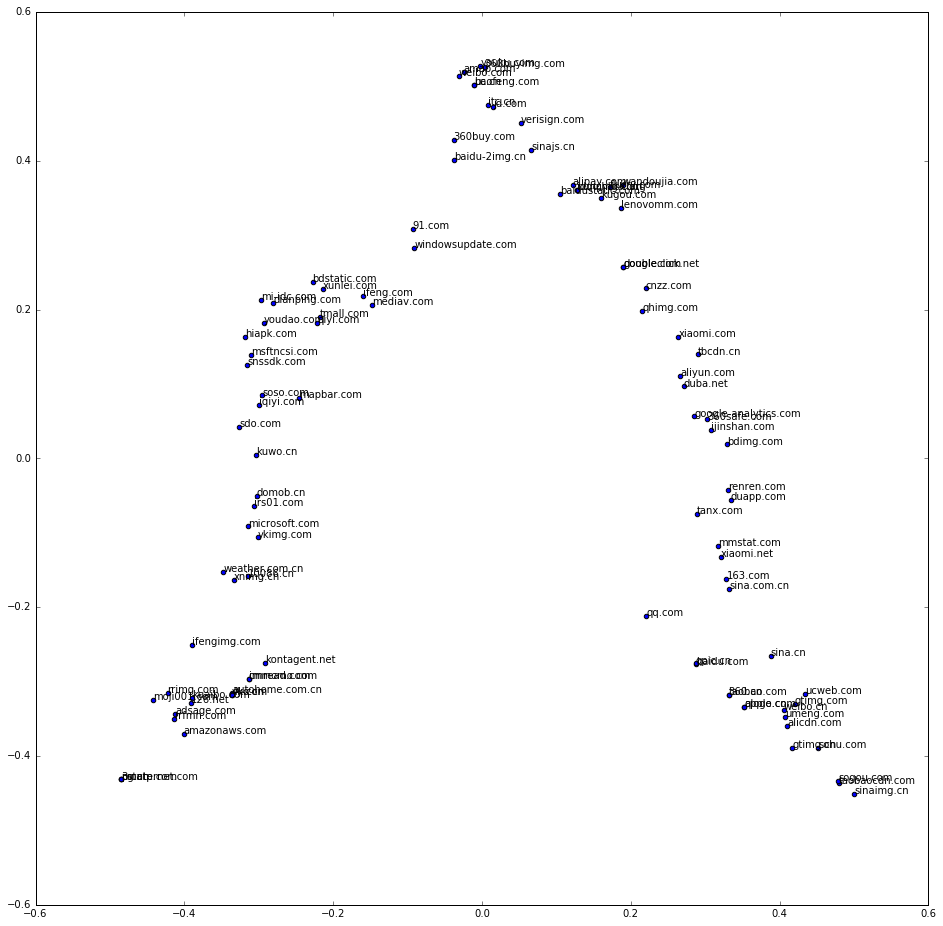

In [61]:
# Perform Spectral Embedding.
topN = 100
data = diif[:topN]
se = manifold.SpectralEmbedding(n_components=2, n_neighbors=10)
trans_data = se.fit_transform(data).T

fig = plt.figure(figsize=(16, 16),facecolor='white')
plt.scatter(trans_data[0], trans_data[1])  # c=colors
for i in range(topN):
    plt.text(trans_data[0][i], trans_data[1][i], diif.index[i], fontsize = 10)  # c=colors

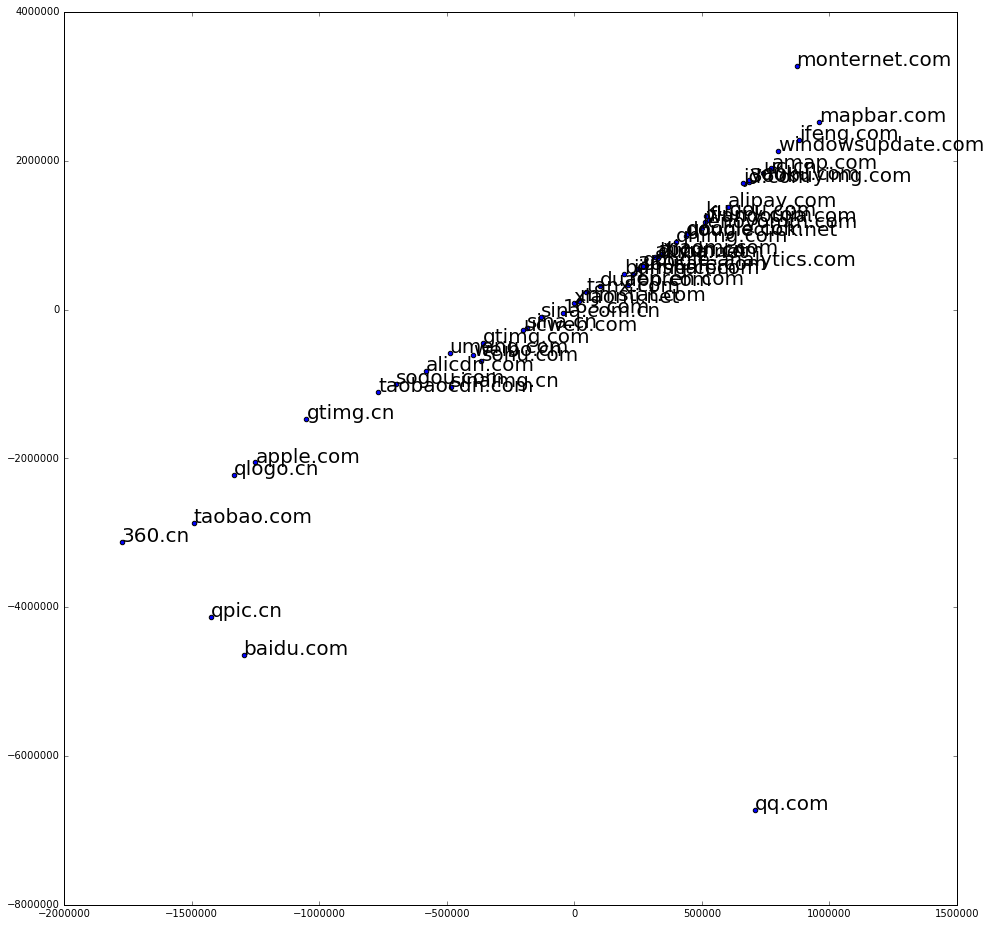

In [58]:
# Perform Multi-dimensional scaling.
mds = manifold.MDS(2, max_iter=100, n_init=1)
trans_data = mds.fit_transform(data).T
fig = plt.figure(figsize=(16, 16),facecolor='white')
plt.scatter(trans_data[0], trans_data[1])  # c=colors
for i in range(50):
    plt.text(trans_data[0][i], trans_data[1][i], diif.index[i], fontsize = 20)  # c=colors

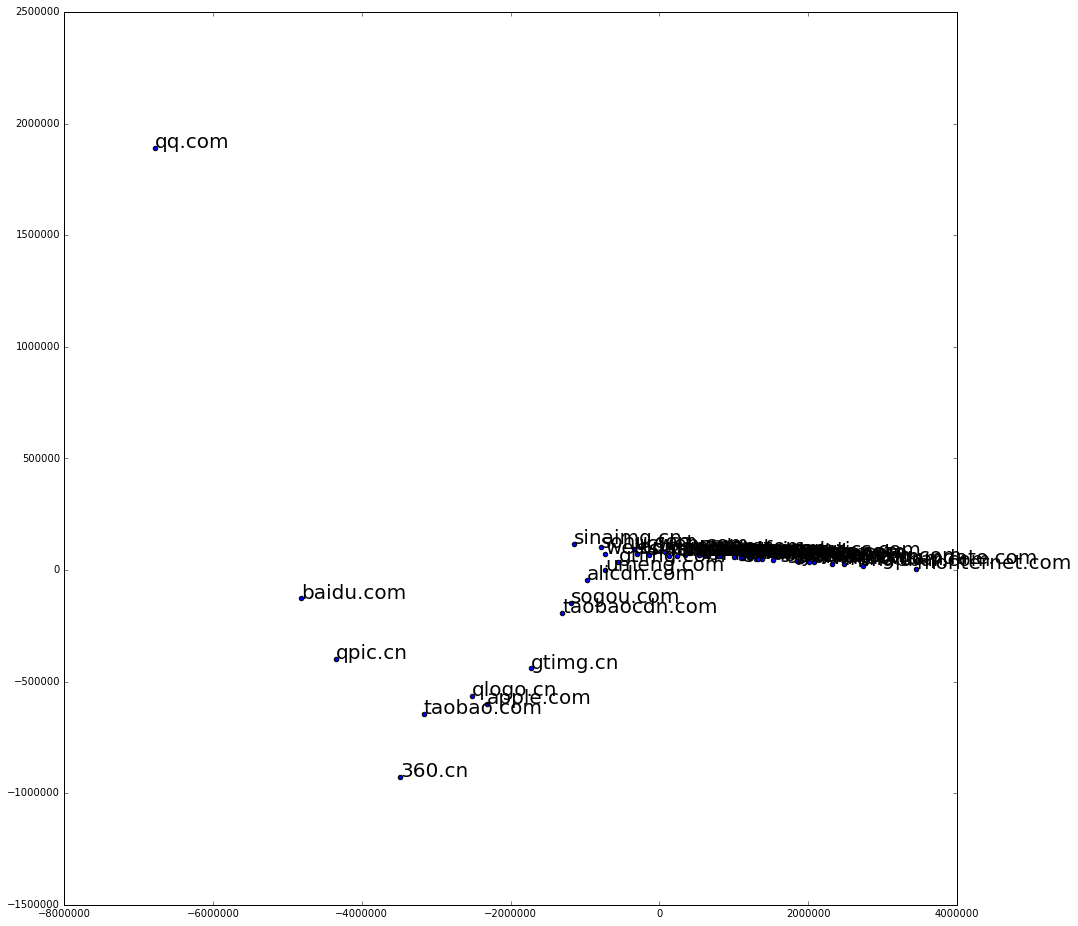

In [56]:
trans_data = manifold.Isomap(n_neighbors=10, n_components=2)\
    .fit_transform(data).T
fig = plt.figure(figsize=(16, 16),facecolor='white')
plt.scatter(trans_data[0], trans_data[1])  # c=colors
for i in range(50):
    plt.text(trans_data[0][i], trans_data[1][i], diif.index[i], fontsize = 20)  # c=colors

In [249]:
toSink,totalflow,fromSource, flowdistance, duration_i, uv_i = np.array(dii.values()).T
toflow = totalflow-toSink
fromflow = totalflow - fromSource

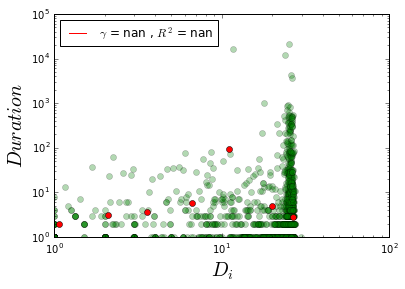

In [255]:
alloRegressPlot(flowdistance,fromSource,'g','o','$D_i$','$Duration$', True)

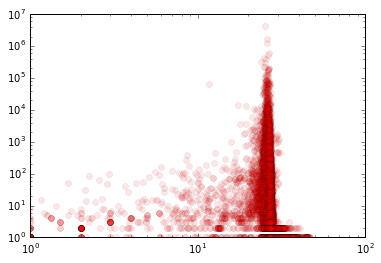

In [251]:
plt.plot(flowdistance, duration_i,'ro', alpha = .1)
plt.xscale('log')
plt.yscale('log')
plt.show()

# Freeman Centralization

# Gravity Law

http://wiki.swarma.net/index.php/%E6%B5%81%E7%BD%91%E7%BB%9C%E7%9A%84%E5%BC%95%E5%8A%9B%E5%AE%9A%E5%BE%8B

$f_{i,j} = c T_i^\alpha T_j^\beta$

In [ ]:
# G=nx.Graph()
# for edge in g.edges():
#     if 'sink' not in edge and 'source' not in edge:
#         observed_duplication = len(set(C_df['uid'].iloc[book_groups[edge[0]]]) \
#                            & set(C_df['uid'].iloc[book_groups[edge[1]]])) / user_sum
#         expected_duplication = (len(book_groups[edge[0]])/user_sum) * (len(book_groups[edge[1]])/user_sum)
#         if  observed_duplication >= expected_duplication:
#             G.add_edge(edge[0], edge[1])

In [106]:
g.edges()[:5]

[('iseesoft.cn', 'yihaodianimg.com'),
 ('niijhsk.com', '126.com'),
 ('guomob.com', 'kuwo.cn'),
 ('guomob.com', '360.cn'),
 ('guomob.com', 'guomob.com')]

In [159]:
edges = g.edges(data=True)
for i in edges[:5]:
    print di[i[0]][1], di[i[1]][1], i[2].values()[0]

1 3951 1
1 2357 1
8717 20633 1
8717 331091 2
8717 30 3


In [160]:
edge_data = [[di[i[0]][1], di[i[1]][1], i[2].values()[0]] for i in edges]

In [161]:
len(edge_data)

363920

In [213]:
ti,tj,fij = np.array(edge_data).T

In [208]:
data = pd.DataFrame({'ti':ti, 'tj':tj, 'y': y, 'xi':xi, 'xj':xj, 'fij':fij})
data = data[data.ti > 0]
data = data[data.tj > 0]

data.describe()

,fij,ti,tj,xi,xj,y
count,359583.000000,3.595830e+05,3.595830e+05,359583.000000,359583.000000,359583.000000
mean,29.116780,7.849408e+04,7.822492e+04,7.438026,7.418889,0.991331
std,1222.386645,2.654431e+05,2.658077e+05,3.520848,3.521415,1.327573
min,1.000000,1.000000e+00,1.000000e+00,0.000000,0.000000,0.000000
25%,1.000000,1.220000e+02,1.190000e+02,4.804021,4.779123,0.000000
50%,2.000000,2.058000e+03,2.021000e+03,7.629490,7.611348,0.693147
75%,5.000000,3.022600e+04,2.976100e+04,10.316458,10.300954,1.609438
max,444809.000000,1.706835e+06,1.706835e+06,14.350151,14.350151,13.005400


In [230]:
import statsmodels.formula.api as smf


data = pd.DataFrame({'ti':ti, 'tj':tj, 'fij':fij})
data = data[data.ti > 10000]
data = data[data.tj > 10000]
data['xi'] = np.log(data.ti)
data['xj'] = np.log(data.tj)
data['y'] = np.log(data.fij)

lm = smf.ols(formula='y ~ xi + xj', data=data).fit()
constant, beta1, beta2 = lm.params
r2=lm.rsquared
print constant, beta1, beta2, r2


-18.5919609421 1.04365908236 1.06471495951 0.448932039549


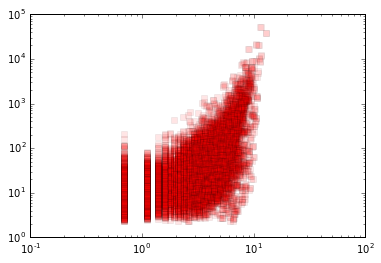

In [231]:
plt.plot(data.y, np.exp(constant)*(data.ti**beta1)*(data.tj**beta2), 'rs', alpha = .1)
plt.xscale('log');plt.yscale('log')

(-2, 2)

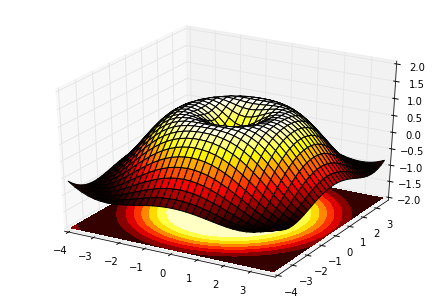

In [225]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()  
ax = Axes3D(fig)  
X = np.arange(-4, 4, 0.25)  
Y = np.arange(-4, 4, 0.25)  
X, Y = np.meshgrid(X, Y)  
R = np.sqrt(X**2 + Y**2)  
Z = np.sin(R)  
  
ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=plt.cm.hot)  
ax.contourf(X, Y, Z, zdir='z', offset=-2, cmap=plt.cm.hot)  
ax.set_zlim(-2,2)  

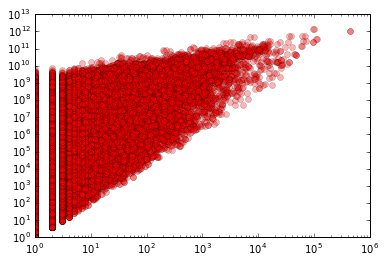

In [183]:
plt.plot(fij, ti*tj, 'ro', alpha = .3)
plt.xscale('log');plt.yscale('log')

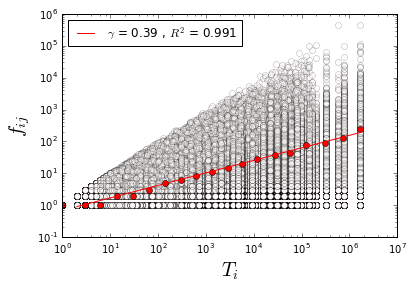

In [244]:
alloRegressPlot(ti, fij,'snow','o','$T_i$','$f_{ij}$', True)

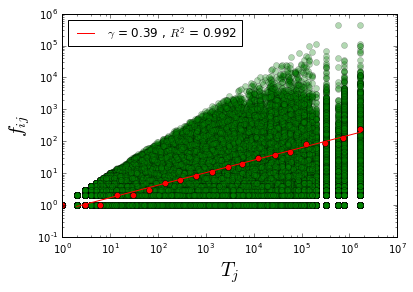

In [236]:
alloRegressPlot(tj, fij,'g','o','$T_j$','$f_{ij}$', True)

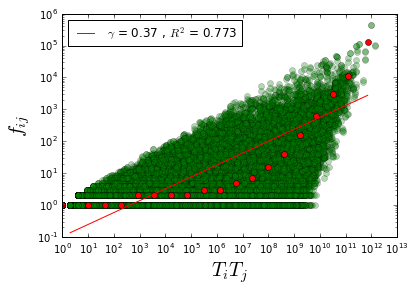

In [232]:
alloRegressPlot(ti*tj, fij,'g','o','$T_i T_j$','$f_{ij}$', True)

In [164]:
res.params

array([ nan,  nan,  nan])

In [ ]:
xi = np.log(ti);xj = np.log(tj)
y = np.log(fij)
x = [[xi[i], xj[i]] for i in range(len(xi))]

xx = sm.add_constant(x, prepend=True)
res = sm.OLS(y,xx).fit()
constant=res.params[0];beta=res.params[1]; r2=res.rsquared
plt.plot(xdata,ydata,mark,color=col, alpha = 0.3)
plt.plot(ti, di, 'ro')
xs = np.linspace(min(ti+1),max(ti+1),100)
plt.plot(xs,np.exp(constant)*xs**beta,color='r',linestyle='-', 
         label = '$\\gamma$ = '+ str(np.round(beta,2)) + ' , ' \
     + '$R^2$ = ' + str(np.round(r2,3)))
plt.legend(loc = 0)

# flownetwork package

In [31]:
%matplotlib inline
from flownetwork import flownetwork as fn
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

print fn.__version__


$version = 0.0.0.9$


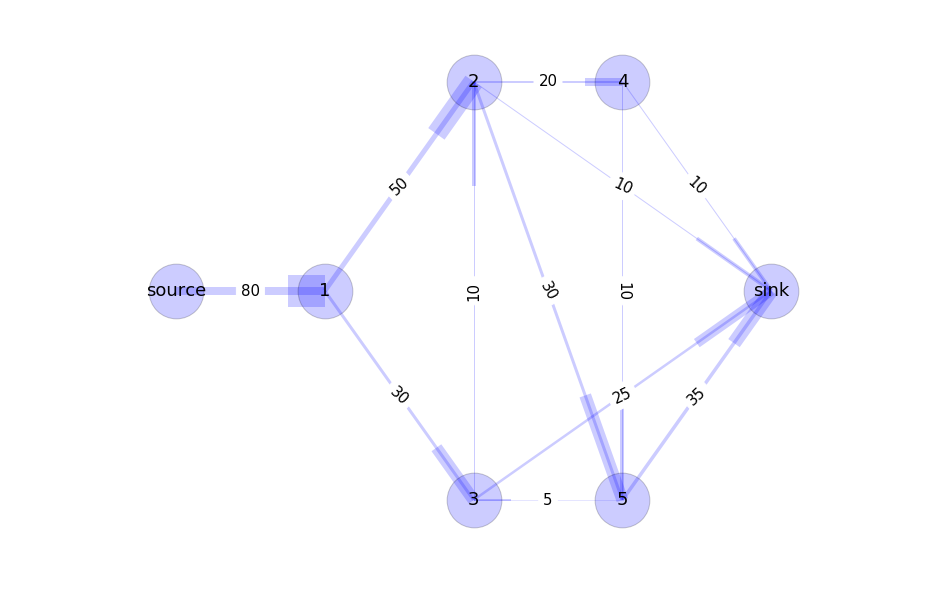

In [2]:
G = nx.DiGraph()
G.add_edge(1, 2, weight = 50)
G.add_edge(1, 3, weight = 30)
G.add_edge(3, 2, weight = 10)
G.add_edge(2, 4, weight = 20)
G.add_edge(2, 5, weight = 30)
G.add_edge(5, 3, weight = 5)
G.add_edge(4, 5, weight = 10)

G = fn.flowBalancing(G)

fig = plt.figure(figsize=(16, 10),facecolor='white')     
pos={1: np.array([ 0.2,  0.5]),
 2: np.array([ 0.4,  0.8]),
 3: np.array([ 0.4,  0.2 ]),
 4: np.array([ 0.6,  0.8]),
 5: np.array([ 0.6,  0.2]),
 'sink': np.array([ 0.8,  0.5]),
 'source': np.array([0,  0.5])}

width=[float(d['weight']*.1) for (u,v,d) in G.edges(data=True)]
edge_labels=dict([((u,v,),d['weight']) for u,v,d in G.edges(data=True)])
nx.draw_networkx_edge_labels(G,pos,edge_labels=edge_labels, font_size = 15,alpha = .5)
nx.draw(G, pos, node_size = 3000, node_color = 'blue', 
        alpha = 0.2, width = width, edge_color='blue',style='solid')
nx.draw_networkx_labels(G,pos,font_size=18)
# plt.savefig('/Users/chengjun/百度云同步盘/Writing/AJOC CSS Special Issue/figures/demo.png', dpi = 400)
plt.show() 


In [186]:
g.nodes().index('source'), g.nodes().index('sink'), len(g)

(4292, 23717, 25752)

In [3]:
help(fn.constructFlowNetwork)

Help on function constructFlowNetwork in module flownetwork.flownetwork:

constructFlowNetwork(C)
    C is an array of two dimentions, e.g., 
    C = np.array([[user1, item1], 
                  [user1, item2], 
                  [user2, item1], 
                  [user2, item3]])
    Return a balanced flow network



In [7]:
fn.getAICI(G)

{1: [80.0, 235.0],
 2: [60.0, 124.99999999999997],
 3: [35.0, 55.0],
 4: [20.0, 31.818181818181813],
 5: [40.0, 46.904761904761891]}

In [8]:
fn.networkDissipate(G)

defaultdict(<function flownetwork.flownetwork.<lambda>>,
            {1: [0, 80, 80],
             2: [10, 60, 0],
             3: [25, 35, 0],
             4: [10, 20, 0],
             5: [35, 40, 0]})

In [9]:
fn.flowDistanceFromSource(G)

{1: 1.0,
 2: 2.223639455782313,
 3: 2.352324263038549,
 4: 3.2236394557823136,
 5: 3.4736394557823136,
 'sink': 3.935728458049887}

In [34]:
help(plt.savefig)

Help on function savefig in module matplotlib.pyplot:

savefig(*args, **kwargs)
    Save the current figure.
    
    Call signature::
    
      savefig(fname, dpi=None, facecolor='w', edgecolor='w',
              orientation='portrait', papertype=None, format=None,
              transparent=False, bbox_inches=None, pad_inches=0.1,
              frameon=None)
    
    The output formats available depend on the backend being used.
    
    Arguments:
    
      *fname*:
        A string containing a path to a filename, or a Python
        file-like object, or possibly some backend-dependent object
        such as :class:`~matplotlib.backends.backend_pdf.PdfPages`.
    
        If *format* is *None* and *fname* is a string, the output
        format is deduced from the extension of the filename. If
        the filename has no extension, the value of the rc parameter
        ``savefig.format`` is used.
    
        If *fname* is not a string, remember to specify *format* to
        ensur

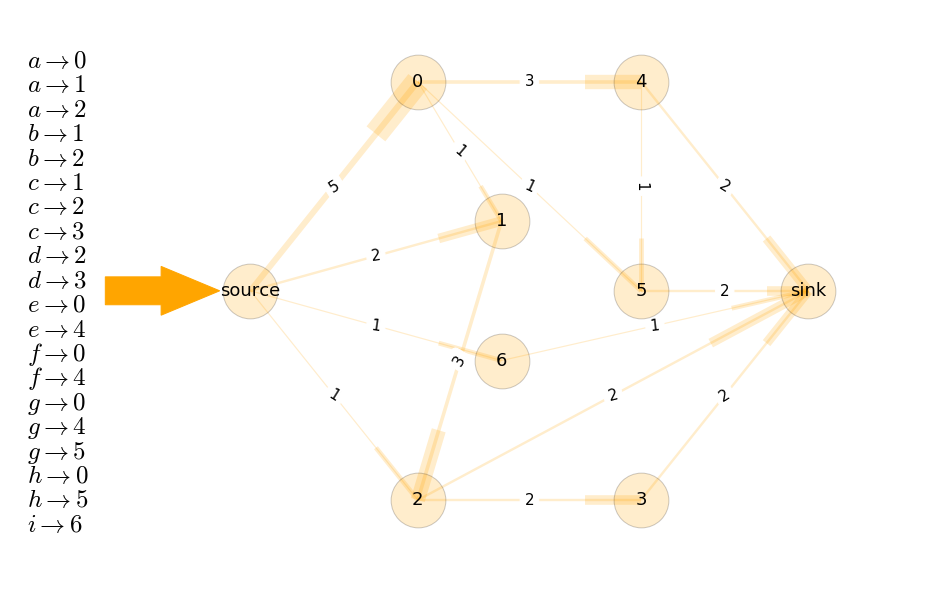

In [38]:
demo = fn.attention_data
gd = fn.constructFlowNetwork(demo)

import numpy as np

fig = plt.figure(figsize=(16, 10),facecolor='white')     
pos={0: np.array([ 0.6 ,  0.8]),
 2: np.array([ 0.6,  0.2]),
 1: np.array([ 0.75,  0.6]),
 6: np.array([ 0.75,  0.4]),
 4: np.array([ 1,  0.8]),
 5: np.array([ 1,  0.5]),
 3: np.array([ 1,  0.2 ]),
 'sink': np.array([ 1.3,  0.5]),
 'source': np.array([.3,  0.5])}
width=[float(d['weight']*1.2) for (u,v,d) in gd.edges(data=True)]
edge_labels=dict([((u,v,),d['weight']) for u,v,d in gd.edges(data=True)])
nx.draw_networkx_edge_labels(gd,pos,edge_labels=edge_labels, font_size = 15,alpha = .5)
nx.draw(gd, pos, node_size = 3000, node_color = 'orange', 
        alpha = 0.2, width = width, edge_color='orange',style='solid')
nx.draw_networkx_labels(gd,pos,font_size=18)
for k,  i in enumerate(demo):
    plt.text(-.1, .82-.035*k, '$%s  \\rightarrow  %i$' % (i[0], i[1]) , fontsize = 25)
plt.arrow(.04, .5,  .1, 0, color='orange', width=0.04, head_width = .07)   
plt.xlim(-.1, 1.5)
plt.savefig('/Users/chengjun/百度云同步盘/Writing/AJOC CSS Special Issue/figures/demo.tiff', dpi = 400)
plt.show() 


In [39]:
127.9*1.8

230.22000000000003

In [68]:
demo

[['a', 0],
 ['a', 1],
 ['a', 2],
 ['b', 1],
 ['b', 2],
 ['c', 1],
 ['c', 2],
 ['c', 3],
 ['d', 2],
 ['d', 3],
 ['e', 0],
 ['e', 4],
 ['f', 0],
 ['f', 4],
 ['g', 0],
 ['g', 4],
 ['g', 5],
 ['h', 0],
 ['h', 5],
 ['i', 6]]

In [6]:
nx.info(gd)

'Name: \nType: DiGraph\nNumber of nodes: 9\nNumber of edges: 15\nAverage in degree:   1.6667\nAverage out degree:   1.6667'

In [8]:
gh = fn.flowBalancing(gd)
nx.info(gh)

'Name: \nType: DiGraph\nNumber of nodes: 9\nNumber of edges: 15\nAverage in degree:   1.6667\nAverage out degree:   1.6667'

In [14]:
m = fn.getFlowMatrix(gd)
m

matrix([[ 0.,  1.,  0.,  0.,  3.,  1.,  0.,  0.,  0.],
        [ 0.,  0.,  3.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  2.,  0.,  0.,  0.,  0.,  2.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  2.],
        [ 0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  2.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  2.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.],
        [ 5.,  2.,  1.,  0.,  0.,  0.,  1.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]])

In [26]:
M = fn.getMarkovMatrix(m)
M

array([[ 0.        ,  0.55555556,  0.22222222,  0.11111111,  0.        ,
         0.        ,  0.        ,  0.11111111,  0.        ],
       [ 0.        ,  0.        ,  0.2       ,  0.        ,  0.        ,
         0.6       ,  0.2       ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  1.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.5       ,
         0.        ,  0.        ,  0.        ,  0.5       ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  1.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.33333333,  0.        ,  0.66666667],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  1.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0

In [29]:
U = fn.getUmatrix(gh)

matrix([[ 1.        ,  0.2       ,  0.2       ,  0.1       ,  0.6       ,
          0.4       ,  0.        ],
        [ 0.        ,  1.        ,  1.        ,  0.5       ,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  1.        ,  0.5       ,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  1.        ,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ,  1.        ,
          0.33333333,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          1.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  1.        ]])

In [87]:
ai, ci

(array([ 80.,  60.,  35.,  20.,  40.]),
 array([ 235.        ,  125.        ,   55.        ,   31.81818182,
          46.9047619 ]))

(20.0, 80.0)

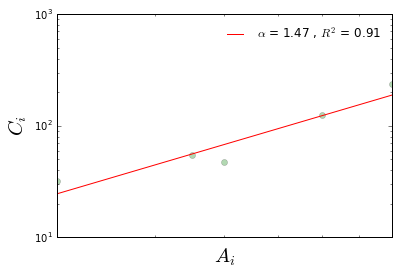

In [86]:
ai, ci = fn.getAICI(G).T
fn.alloRegressPlot(ai,ci,'g','o','$A_i$','$C_i$', loglog=True)
plt.xlim(np.min(ai), np.max(ai))

In [17]:
fn.networkDissipate(gh)

defaultdict(<function flownetwork.flownetwork.<lambda>>,
            {0: [0, 5, 5],
             1: [0, 3, 2],
             2: [2, 4, 1],
             3: [2, 2, 0],
             4: [2, 3, 0],
             5: [2, 2, 0],
             6: [1, 1, 1]})

In [16]:
fn.flowDistanceFromSource(gd)

{0: 1.0,
 1: 1.333333333333333,
 2: 2.0,
 3: 3.0,
 4: 2.0,
 5: 2.5,
 6: 1.0,
 'sink': 3.2222222222222214}

In [10]:
fn.outflow(gd, 1)

3

In [11]:
fn.inflow(gd, 1)

3

In [12]:
fn.averageFlowLength(gd)

3.2222222222222223

In [35]:
# fn.getAverageTimeMatrix(gd)

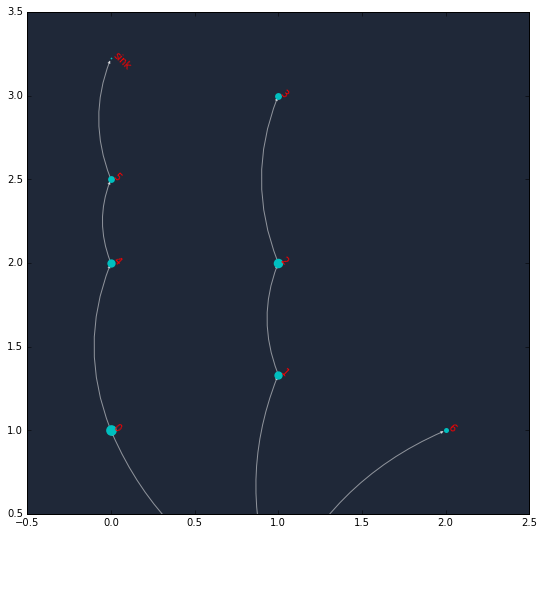

In [21]:
fig = plt.figure(figsize=(9, 9),facecolor='white')
ax = fig.add_subplot(111)
fn.plotTree(gh,ax)
plt.show()

In [13]:
ai, ci = fn.getAICI(gd).T
print ai, ci

[ 5.  3.  4.  2.  3.  2.  1.] [ 12.5   7.5   6.    2.    4.    2.    1. ]


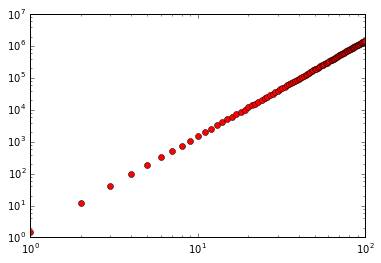

In [89]:
from random import random
x = np.array(range(1, 100))
y = (x+random()*x)**3

plt.plot(x, y, 'ro')
plt.xscale('log');plt.yscale('log')
plt.show()

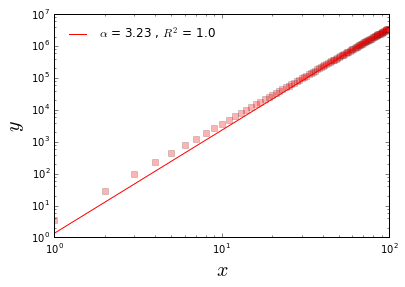

In [35]:
fn.alloRegressPlot(x,y,'r','s','$x$','$y$', loglog=True)

[-0.0099301962503268171,
 -0.064764460567964449,
 -0.17705123513352666,
 0.89999847894045781]

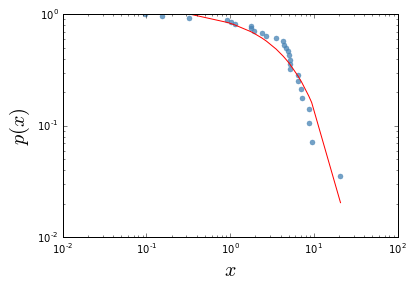

In [23]:
rg = np.array([ 20.7863444 ,   9.40547933,   8.70934714,   8.62690145,
     7.16978087,   7.02575052,   6.45280959,   6.44755478,
     5.16630287,   5.16092884,   5.15618737,   5.05610068,
     4.87023561,   4.66753197,   4.41807645,   4.2635671 ,
     3.54454372,   2.7087178 ,   2.39016885,   1.9483156 ,
     1.78393238,   1.75432688,   1.12789787,   1.02098332,
     0.92653501,   0.32586582,   0.1514813 ,   0.09722761])
fn.powerLawExponentialCutOffPlot(rg, '$x$', '$P(x)$')

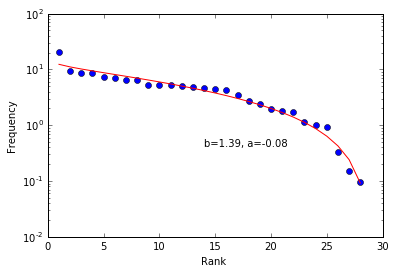

In [24]:
fn.DGBDPlot(rg)

Calculating best minimal value for power law fit


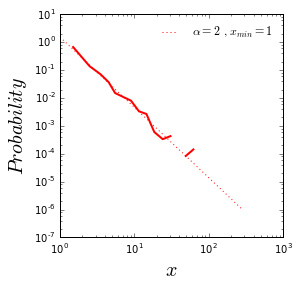

In [3]:
from networkx.utils import powerlaw_sequence
pl_sequence = powerlaw_sequence(1000,exponent=2.5)

fig = plt.figure(figsize=(4, 4),facecolor='white')
ax = fig.add_subplot(111)
fn.plotPowerlaw(pl_sequence,ax,'r','$x$')


Calculating best minimal value for power law fit


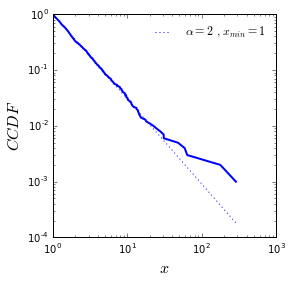

In [4]:
fig = plt.figure(figsize=(4, 4),facecolor='white')
ax = fig.add_subplot(111)
fn.plotCCDF(pl_sequence,ax,'b','$x$')


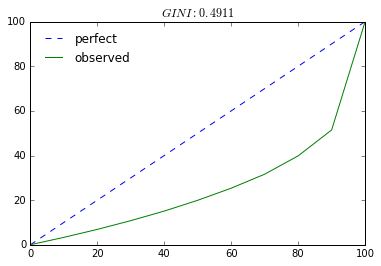

In [17]:
bins, result, gini_val = fn.gini_coefficient(np.array(pl_sequence))

plt.plot(bins, bins, '--', label="perfect")
plt.plot(bins, result, label="observed")
plt.title("$GINI: %.4f$" %(gini_val))

plt.legend(loc = 0, frameon = False)
plt.show()

In [28]:
127.9*1.8*6

1381.3200000000002